In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from PIL import Image
from scipy import ndimage
from sklearn import preprocessing
import scipy
from sklearn.decomposition import PCA
from scipy.special import expit
np.random.seed(1)

In [2]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train, y_train, X_test, y_test, classes = load_dataset()
X_train = X_train/255
X_test = X_test/255
y_train = y_train.T
y_test = y_test.T

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(209, 64, 64, 3)
(209, 1)
(50, 64, 64, 3)
(50, 1)


In [4]:
def evenly_distribute(data): # Dataset (include X_train and y_train)
    negative = data[data[:, -1] == 0]
    positive = data[data[:, -1] == 1]
    negative_shrunk = negative[:len(positive), :]
    data = np.concatenate((positive, negative_shrunk))
    np.random.seed(42) 
    np.random.shuffle(data)
    return data

In [5]:
X_train = X_train.reshape((209, 12288))
X_test = X_test.reshape((50, 12288))
train_data = np.concatenate((X_train, y_train), axis=1)
test_data = np.concatenate((X_test, y_test), axis=1)
data = np.concatenate((train_data, test_data))
data = evenly_distribute(data)
data.shape

(210, 12289)

In [6]:
from sklearn.model_selection import train_test_split

training, test = train_test_split(data,
                                test_size=0.3, 
                                random_state=42)

X_train = training[:, :-1]
y_train = np.reshape(training[:, -1], (len(X_train), 1))
X_test = test[:, :-1]
y_test = np.reshape(test[:, -1], (len(X_test), 1))

In [7]:
training.shape

(147, 12289)

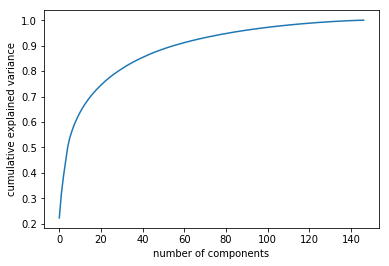

In [8]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [9]:
X_train.shape

(147, 12288)

In [10]:
for k in range(10, 200):
    S = pca.explained_variance_ratio_
    if sum(S[:k]) / sum(S) >= 0.99:
        K = k # reduced num of features
        print(k)
        break

124


In [11]:
pca = PCA(n_components=K)

X_combined = np.concatenate([X_train, X_test])
X_combined = pca.fit_transform(X_combined)
X_train_reduced = X_combined[:len(X_train), :]
X_test_reduced = X_combined[len(X_train):, :]

In [15]:
X_train_reduced.shape

(147, 124)

In [28]:
def sigmoid(z):
    z = np.ones(z.shape) / (1 + np.exp(-z))
    return z

# return cost function and partial derivatives for gradient
def nn(nn_params, X, y):
    input_layer_size = K # 124 not 171 after reducing dataset so num pos and neg ex are equal
    hidden_layer_size = 500   
    num_labels = 1                
    reg_lambda = 0
    ones = np.reshape(np.ones(len(X)), (len(X), 1))
    X = np.concatenate((ones, X), axis=1)

    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                     (hidden_layer_size, (input_layer_size + 1)))
    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                     (num_labels, (hidden_layer_size + 1)))

    m = len(X) 
    Theta1_grad = np.zeros(Theta1.shape) 
    Theta2_grad = np.zeros(Theta2.shape) 
    
    a1 = X  # (209, 172)
    z2 = a1 @ Theta1.T  # (209, 172) * (172, 114) => 209 x 114
    a2 = sigmoid(z2)  # 209 x 114
    a2 = np.hstack((np.ones((len(X), 1)), a2)) # 209 x 115
    z3 = a2 @ Theta2.T # 209 x 115 * 115 x 1
    a3 = sigmoid(z3)   # 209 x 1
    pre_allocated = np.empty_like(a3)
    d3 = np.subtract(a3, y, out=pre_allocated)
    d2 = d3 @ Theta2[:, 1:] * sigmoid(z2)  # 209 x 1 * 1 x 114 => 209 x 114
   
    Theta1_grad = 1/m * (Theta1_grad + d2.T @ a1)  # 114 x 209 * 209 x 172 => (114, 172)
    Theta2_grad = 1/m * (Theta2_grad + d3.T @ a2)  # 1 x 209 * 209 x 115  => (1, 115)   
    
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + 1/m * (reg_lambda * Theta1[:, 1:])  
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + 1/m * (reg_lambda * Theta2[:, 1:])    

    term1 = expit(np.log(a3))
    term2 = expit(np.log(1 - a3))
    
    J = -1/m * (sum(sum(y * term1 + (1 - y) * term2)))
    + reg_lambda/(2*m) * (sum(sum(Theta1[:, 1:] ** 2)) + sum(sum(Theta2[:, 1:] ** 2))) 

    grad = np.concatenate((np.ravel(Theta1_grad), np.ravel(Theta2_grad))) # Unroll gradients
    return J, grad

def CostFunc(nn_params, X, y):
    J = nn(nn_params, X, y)[0]
    return J
def Gradient(nn_params, X, y):
    grad = nn(nn_params, X, y)[1]
    return grad

In [29]:
input_layer_size  = K  # 172 features
hidden_layer_size = 500   # (2/3 the size of input layer)
num_labels = 1          # cat or noncat

Theta1 = np.random.uniform(size=(hidden_layer_size, input_layer_size + 1)) # size([# hidden units], [# input units + 1])
Theta2 = np.random.uniform(size=(num_labels, hidden_layer_size + 1))  # size([# output units], [# hidden units + 1])
nn_params = np.concatenate((np.ravel(Theta1), np.ravel(Theta2)))
Trial = Gradient(nn_params, X_train_reduced, y_train)
Trial

/Users/eloisezeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


array([0.04513457, 0.39170854, 0.15035672, ..., 0.254408  , 0.25918753,
       0.25310993])

In [30]:
import scipy.optimize as op

input_layer_size  = K  # 124 features
hidden_layer_size = 500   # (2/3 the size of input layer)
num_labels = 1          # cat or noncat
 
Theta1 = np.random.uniform(size=(hidden_layer_size, input_layer_size + 1)) # hidden_layer_size x (input_layer_size + 1)
Theta2 = np.random.uniform(size=(num_labels, hidden_layer_size + 1))  # size([# output units], [# hidden units + 1])
nn_params = np.concatenate((np.ravel(Theta1), np.ravel(Theta2)))

Result = op.minimize(fun = CostFunc, 
                    x0 = nn_params, 
                    args = (X_train_reduced, y_train),
                    jac = Gradient, method='TNC') 

nn_params = Result.x # optimal theta
Result

/Users/eloisezeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


     fun: -0.24986811686478466
     jac: array([0.22812203, 1.78348198, 0.29956823, ..., 0.24247415, 0.25404566,
       0.23240786])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 53
     nit: 1
  status: 1
 success: True
       x: array([0.46316163, 0.76592633, 0.54371069, ..., 0.91786762, 0.33470008,
       0.78353406])

In [31]:
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                     (hidden_layer_size, (input_layer_size + 1)))
Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                     (num_labels, (hidden_layer_size + 1)))
def predict(Theta1, Theta2, X):
    m = len(X)
    num_labels = Theta2.shape[0]
    
    X = np.hstack((np.ones((len(X), 1)), X)) # (209, 172)
    a1 = X  # (209, 172)
    z2 = a1 @ Theta1.T  # (209, 172) * (172, 114) => 209 x 114
    a2 = sigmoid(z2)  # 209 x 114
    a2 = np.hstack((np.ones((len(X), 1)), a2)) # 209 x 115
    z3 = a2 @ Theta2.T # 209 x 115 * 115 x 1
    a3 = sigmoid(z3)   # 209 x 1
    a3[a3 >= 0.5] = 1
    a3[a3 < 0.5] = 0
    
    return a3

accuracy = sum(sum(predict(Theta1, Theta2, X_train_reduced) == y_train)) / len(X_train_reduced)
print(str(round(accuracy * 100, 2)) + " %")
accuracy = sum(sum(predict(Theta1, Theta2, X_test_reduced) == y_test)) / len(X_test_reduced)
print(str(round(accuracy * 100, 2)) + " %")

48.3 %
53.97 %


In [32]:
from sklearn.metrics import f1_score, confusion_matrix
print(f1_score(y_train, predict(Theta1, Theta2, X_train_reduced), average=None), '\n')
print(f1_score(y_test, predict(Theta1, Theta2, X_test_reduced), average=None), '\n')
# 0.73 F1-score when there's cat. 
# 0.58 F1-score when there's no cat. 

[0.         0.65137615] 

[0.         0.70103093] 



In [33]:
print(confusion_matrix(y_train, predict(Theta1, Theta2, X_train_reduced)), '\n')
print(confusion_matrix(y_test, predict(Theta1, Theta2, X_test_reduced)))

[[ 0 76]
 [ 0 71]] 

[[ 0 29]
 [ 0 34]]


In [34]:
print(sum(y_test == 1) / len(y_test))
print(sum(y_train == 1) / len(y_train))
data = np.concatenate((y_train, y_test))
print(sum(data == 1) / len(data)) # 48 % of images are cats

[0.53968254]
[0.4829932]
[0.5]
